In [1]:
# Install Dependencies
!pip install -q grad-cam opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s 

In [2]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json here
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ChestXrayDataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:15<00:00, 91.8MB/s]
100% 2.29G/2.29G [00:15<00:00, 161MB/s] 


In [10]:
# Verify Folder Structure & Counts
base = "/content/ChestXrayDataset/chest_xray"
for split in ["train","val","test"]:
    for label in ["NORMAL","PNEUMONIA"]:
        path = os.path.join(base, split, label)
        print(f"{split}/{label}: {len(os.listdir(path))} images")

train/NORMAL: 1341 images
train/PNEUMONIA: 3875 images
val/NORMAL: 8 images
val/PNEUMONIA: 8 images
test/NORMAL: 234 images
test/PNEUMONIA: 390 images


In [11]:
# Copy to Project Workspace
import shutil

project_dir = '/content/ChestXrayProject'
shutil.copytree(base, project_dir)
print("Data ready at:", project_dir)

Data ready at: /content/ChestXrayProject


In [12]:
# Data Preprocessing & Dataloaders (PyTorch)
# Define Transforms (ResNet-50 Friendly: 224×224)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [13]:
# Create Datasets & Dataloaders
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_dir = "/content/ChestXrayProject/chest_xray"

train_data = ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_data = ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)
test_data = ImageFolder(root=f"{data_dir}/test", transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['NORMAL', 'PNEUMONIA']


In [14]:
# Build ResNet-50 for Pneumonia Detection
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: NORMAL & PNEUMONIA

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [15]:
# Define Loss, Optimizer, and Scheduler
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [16]:
# Training and Evaluation Loop
# Define Train & Validate Functions
from tqdm import tqdm
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, save_path):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print("🔸 Best model updated and saved.")

        scheduler.step()

    print(f"\n✅ Training complete. Best val acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# Start Training
save_model_path = "/content/resnet50_best.pth"
num_epochs = 10  # Increase later if needed

trained_model = train_model(model, criterion, optimizer, scheduler,
                            num_epochs, train_loader, val_loader, save_model_path)


Epoch 1/10


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Train Loss: 0.2611 | Train Acc: 0.8894
Val Loss: 0.3375 | Val Acc: 0.7500
🔸 Best model updated and saved.

Epoch 2/10


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Train Loss: 0.1641 | Train Acc: 0.9337
Val Loss: 0.3258 | Val Acc: 0.7500

Epoch 3/10


100%|██████████| 163/163 [01:38<00:00,  1.65it/s]


Train Loss: 0.1568 | Train Acc: 0.9329
Val Loss: 0.3171 | Val Acc: 0.7500

Epoch 4/10


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Train Loss: 0.1343 | Train Acc: 0.9486
Val Loss: 0.2862 | Val Acc: 0.8125
🔸 Best model updated and saved.

Epoch 5/10


100%|██████████| 163/163 [01:38<00:00,  1.65it/s]


Train Loss: 0.1291 | Train Acc: 0.9502
Val Loss: 0.3663 | Val Acc: 0.7500

Epoch 6/10


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Train Loss: 0.1335 | Train Acc: 0.9448
Val Loss: 0.3138 | Val Acc: 0.7500

Epoch 7/10


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Train Loss: 0.1279 | Train Acc: 0.9511
Val Loss: 0.3031 | Val Acc: 0.7500

Epoch 8/10


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Train Loss: 0.1347 | Train Acc: 0.9459
Val Loss: 0.3417 | Val Acc: 0.7500

Epoch 9/10


100%|██████████| 163/163 [01:39<00:00,  1.65it/s]


Train Loss: 0.1304 | Train Acc: 0.9503
Val Loss: 0.2754 | Val Acc: 0.8125

Epoch 10/10


100%|██████████| 163/163 [01:38<00:00,  1.65it/s]


Train Loss: 0.1269 | Train Acc: 0.9534
Val Loss: 0.3323 | Val Acc: 0.7500

✅ Training complete. Best val acc: 0.8125


In [38]:
#  Model Evaluation on Test Set
# Load the Best Model
trained_model.load_state_dict(torch.load("/content/resnet50_best.pth"))
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# Evaluate on Test Set with Metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("\n🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


🔍 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.92      0.66      0.77       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



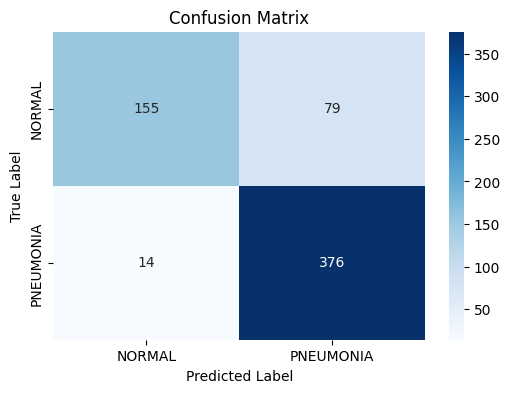

In [21]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
import torch
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your trained model checkpoint
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # binary classification (e.g., pneumonia, TB)
model.load_state_dict(torch.load('resnet50_best.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])
])

In [55]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handlers = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Register forward hook
        self.hook_handlers.append(self.target_layer.register_forward_hook(forward_hook))
        # Register backward hook
        self.hook_handlers.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        target = output[0, class_idx]
        target.backward()

        gradients = self.gradients[0]          # [C, H, W]
        activations = self.activations[0]      # [C, H, W]

        weights = gradients.mean(dim=(1, 2))  # Global average pooling: [C]

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        return cam

    def remove_hooks(self):
        for handle in self.hook_handlers:
            handle.remove()


In [56]:
target_layer = model.layer4[-1].conv3  # The last conv layer in ResNet-50
grad_cam = GradCAM(model, target_layer)

In [58]:
img_path = 'ChestXrayProject/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)  # batch size 1

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


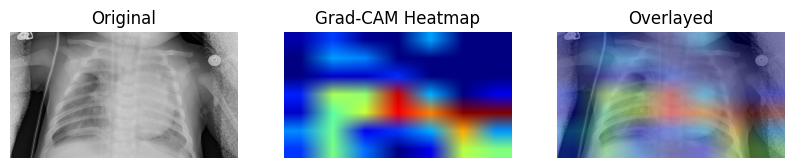

In [59]:
cam = grad_cam.generate(input_tensor)

# Convert heatmap to RGB
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size
heatmap = cv2.resize(heatmap, (img.width, img.height))

# Convert PIL img to numpy array
img_np = np.array(img)

# Overlay heatmap on image with some transparency
overlayed_img = heatmap * 0.4 + img_np * 0.6
overlayed_img = overlayed_img.astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(img_np)

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.axis('off')
plt.imshow(heatmap)

plt.subplot(1, 3, 3)
plt.title('Overlayed')
plt.axis('off')
plt.imshow(overlayed_img)
plt.show()

In [60]:
grad_cam.remove_hooks()

In [61]:
print("Class labels:", class_names)

Class labels: ['NORMAL', 'PNEUMONIA']
